<a href="https://colab.research.google.com/github/Aditib2409/EE-541-Project/blob/main/chords_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/Shareddrives/EE541Project/archive.zip"

### Loading Dataset

In [10]:
class loading_dataset:
    def __init__(self, path):
        self.path = path

    def harmonics(self, file_path, print=False):
        freq, X = wavfile.read(file_path)
        n = len(X)
        X_fourier = fft(X)
        X_fourier_onesided = 2.0/n * np.abs(X_fourier[0:n // 2])
        frequencies = fftfreq(n, 1/freq)[:n//2]
        freqs_50_index = np.argmin(np.abs(frequencies - 50))
        
        ht = np.max(X_fourier_onesided)*5/100
        peaks_found, _ = find_peaks(X_fourier_onesided, distance=10, height=ht)
        peaks_found = peaks_found[peaks_found>freqs_50_index]
        harmonics_found = np.round(frequencies[peaks_found],2)
        
        if print:
            p = np.max(peaks_found) + 100
            plt.plot(frequencies[:p], X_fourier_onesided[:p])
            plt.plot(frequencies[peaks_found], X_fourier_onesided[peaks_found], 'o')
            plt.xlabel(f'Frequency in Hz')
            plt.ylabel(f'Harmonics')
            plt.show()
        
        return harmonics_found

    
    def create_dataframe(self):
        # to track the length of a harmonic
        length_harmonic = 0
        dataset = []

        for dir_name, _, file_name in os.walk(self.path):
            for filename in file_name:
                folder_name = os.path.basename(dir_name)
                full_filepath = os.path.join(dir_name, filename)
                harmonic_peaks = self.harmonics(full_filepath)
                min_harmonics = harmonic_peaks.min()
                max_harmonics = harmonic_peaks.max()
                num_peaks = len(harmonic_peaks)
                length_harmonic = max(num_peaks, length_harmonic)
                current_data = [folder_name, filename, min_harmonics, max_harmonics, num_peaks] 
                current_data.extend(harmonic_peaks)

                dataset.append(current_data)

        feature_cols = ["Chord_type", "File_name", "Minimum_harmonic", "Maximum harmonic", "Num_harmonics"]
        for i in range(length_harmonic):
            feature_cols.append(f'Harmonic {i+1}')

        data_df = pd.DataFrame(dataset, columns=feature_cols)

        return data_df

In [13]:
path = "/content/drive/MyDrive/Audio_Files"
dataloader = loading_dataset(path)
data = dataloader.create_dataframe()
data_og = data

In [14]:
def plot_kde(I, df):
    rows = len(I)
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(8, 15), sharex=True)
    for i in range(rows):
        sns.kdeplot(ax=axes[i], data=df, x=I[i], hue="Chord_type", shade=True, palette="Set2")
        axes[i].set_title(f'{I[i]} density plot')
    plt.show()

In [15]:
def plot_kde_features(I, df):
    fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 35))
    axs = axes.ravel()
    for i in range(len(I)):
        sns.kdeplot(ax=axs[i], data=df, x=I[i], hue="Chord_type", shade=True)
    plt.show()

### Creating intervals

In [16]:
intervals = ["octave", "quinta", "quarta", "major inertia", "minor inertia"]
for i in range(len(intervals)):
    data[intervals[i]] = np.divide(data[f'Harmonic {i+2}'], data[f'Harmonic {i+1}'])

# adding more intervals
for i in range(len(intervals)):
    for j in range(i+1, len(intervals)):
        data[f'interval_{i+1}_{j+1}'] = np.divide(data[intervals[j]], data[intervals[i]])


In [17]:
## gives list of all harmonics that have NANs. we drop those harmonics
data.isnull().sum(axis = 0)

drop_harmonics = data.columns[13:43]
data = data.drop(drop_harmonics, axis=1)

In [18]:
data = data.drop("File_name", axis=1)

In [19]:
new_list = list(data.columns)

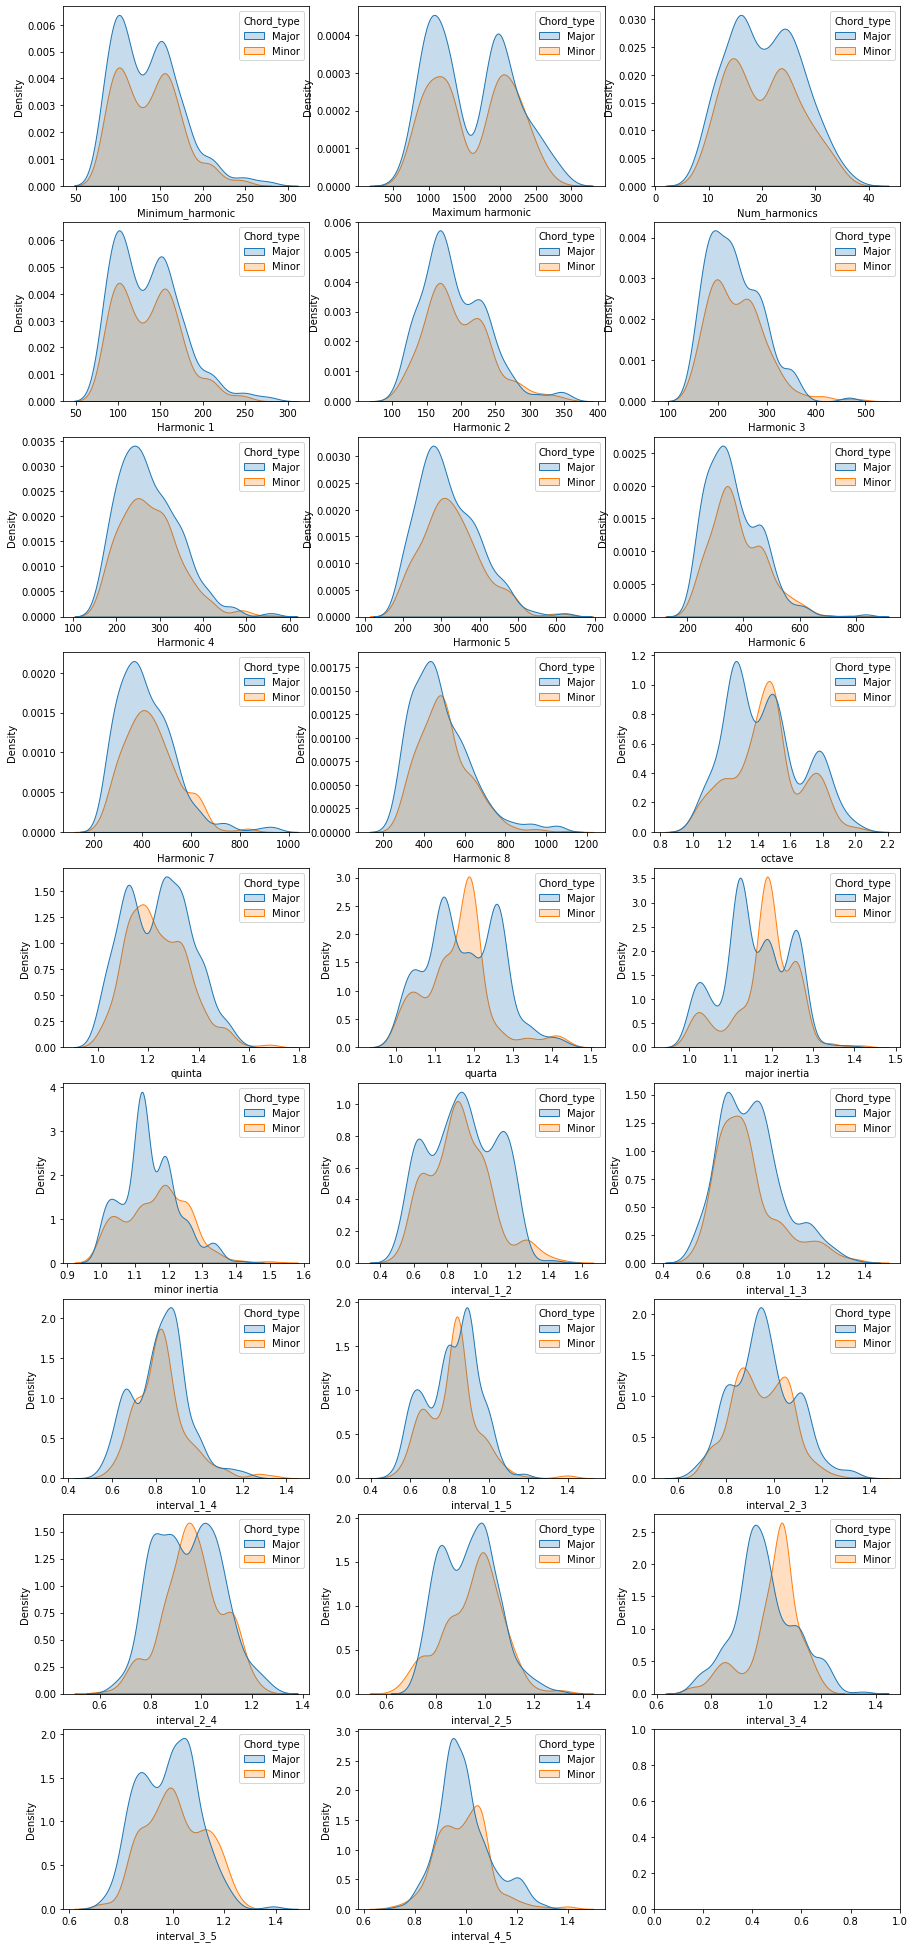

In [20]:
plot_kde_features(new_list[1:], data)

## Principle Component Analysis

In [73]:
data_norm = data.drop("Chord_type", axis=1)
normalizer = StandardScaler()
data_norm = normalizer.fit_transform(data_norm)
y_pca = np.zeros(len(data_norm))
y_pca[np.where(data["Chord_type"] == "Minor")] = 1

In [74]:
pca = PCA()
data_pca = pca.fit_transform(data_norm)

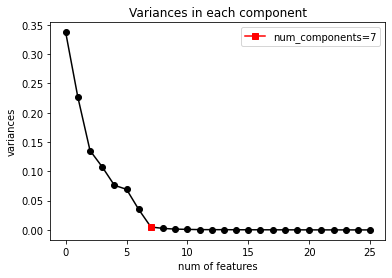

In [84]:
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance, marker='o', color='black')
plt.title('Variances in each component')
plt.xlabel('num of features')
plt.ylabel('variances')
for i in range(len(explained_variance)):
    sum_variances = explained_variance[0:i].sum()
    if sum_variances > 0.98:
        num_components = i
        break
x0 = num_components
y0 = explained_variance[x0]
plt.plot(x0, y0, marker='s', color='red', label=f"num_components={x0}")
plt.legend()
plt.show()

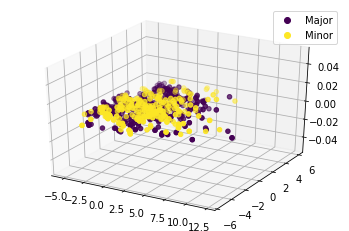

In [80]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot = ax.scatter(data_pca[:,0], data_pca[:,1], c=y_pca)
plt.legend(handles=plot.legend_elements()[0], labels=list(['Major', 'Minor']))

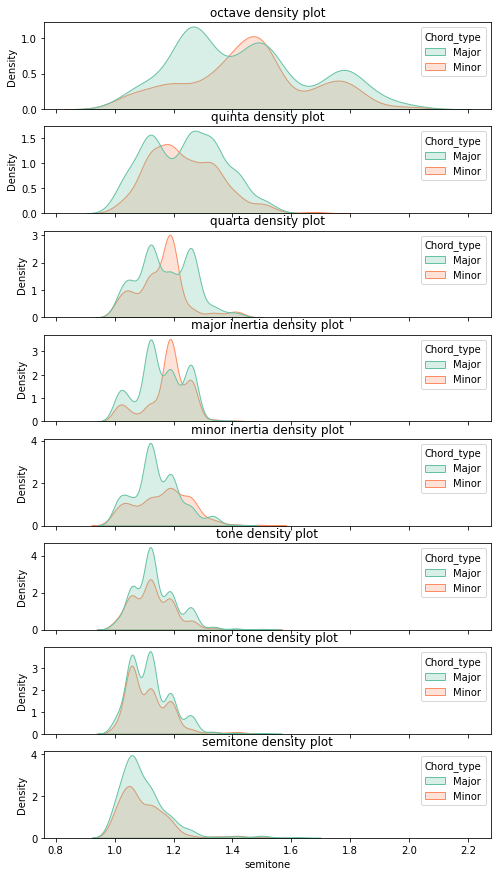

In [93]:
plot_kde(intervals, data)

In [85]:
# get the corresponding intervals
data["Chord_type"] = data["Chord_type"].replace("Major", 0)
data["Chord_type"] = data["Chord_type"].replace("Minor", 1)

In [86]:
train_x, test_x, train_y, test_y = train_test_split(data[intervals], data['Chord_type'], test_size=0.15, random_state=42)

In [88]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15)

In [89]:
train_csv = pd.concat([train_x, train_y], axis=1)
val_csv = pd.concat([val_x, val_y], axis=1)
test_csv = pd.concat([test_x, test_y], axis=1)

In [90]:
train_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Train", encoding='utf-8', index=False)
val_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Val", encoding='utf-8', index=False)
test_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Test", encoding='utf-8', index=False)

# Model Implementation


In [ ]:
X_train = train_x
Y_train = train_y
X_test = val_x
Y_test = val_y

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score

# Functions
def calcAccuracy(labels, preds):
    return np.mean(labels == preds)

def plotConfMat(labels, preds):
    confmat = confusion_matrix(labels, preds)
    p = sns.heatmap(confmat, annot=True, fmt='g')
    p.set_xlabel("Prediction", fontsize = 20)
    p.set_ylabel("Reference", fontsize = 20)
    return p


# Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_pred = nb.predict(X_test)

# SVM:
svc_l = SVC(C=2, kernel='linear')     # Linear kernel
svc_p = SVC(C=2, kernel='poly') # polynomial kernel
svc_r = SVC(C=2, kernel='rbf')        # radial kernel

svc_l.fit(X_train, Y_train)
svc_l_pred = svc_l.predict(X_test)

svc_p.fit(X_train, Y_train)
svc_p_pred = svc_p.predict(X_test)

svc_r.fit(X_train, Y_train)
svc_r_pred = svc_r.predict(X_test)

In [ ]:
print("Naive Bayes:", calcAccuracy(Y_test, nb_pred))
print("SVM Linear:", calcAccuracy(Y_test, svc_l_pred))
print("SVM Polynomial:", calcAccuracy(Y_test, svc_p_pred))
print("SVM Radial:", calcAccuracy(Y_test, svc_r_pred))

Naive Bayes: 0.6434108527131783
SVM Linear: 0.5891472868217055
SVM Polynomial: 0.7286821705426356
SVM Radial: 0.7170542635658915


In [ ]:
print(svc_r_pred)

[0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1
 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
